### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


## Seminar

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp "/content/drive/MyDrive/Colab Notebooks/data/Train_rev1.zip" .
!cp "/content/drive/MyDrive/Colab Notebooks/data/glove.6B.zip" .

In [32]:
!unzip ./glove.6B.zip -y

Archive:  ./glove.6B.zip
caution: filename not matched:  -y


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [5]:
data = pd.read_csv("./Train_rev1.zip", compression="zip", index_col=None)
data.shape

(244768, 12)

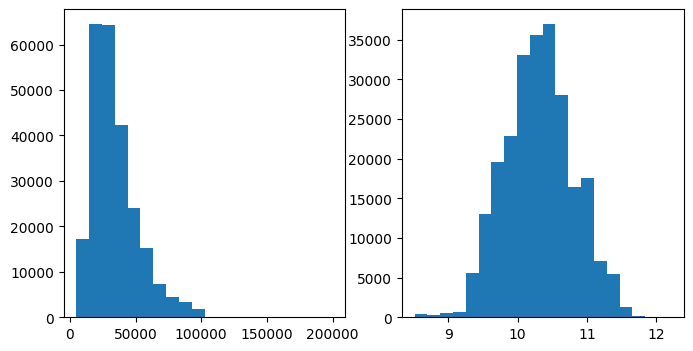

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [7]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
159654,71180058,Insurance Administrator,"Administrator (commercial market) **** ****7,...",London South East,South East London,NaN,permanent,Next Employment,Accounting & Finance Jobs,"From 25,000 to 27,000 per annum",26000,totaljobs.com,10.165891
100495,69540428,Sales Executive,Sales Executive **** ****ent IQX/****/PK We a...,Kent,Kent,NaN,permanent,Freight Personnel,Sales Jobs,35000 - 40000/annum,37500,cv-library.co.uk,10.532123
39681,68353036,Telecoms Field Sales B2B West Midlands: Birm...,Telecoms Field Sales B2B West Midlands: Birm...,Birmingham,Birmingham,full_time,NaN,Additional Resources,Sales Jobs,40000,40000,careerbuilder.com,10.596660


In [8]:
import nltk

def tokenize(x: str) -> str:
    return " ".join(tokenizer.tokenize(x.lower()))

tokenizer = nltk.tokenize.WordPunctTokenizer()
data["FullDescription"] = data["FullDescription"].astype(str).apply(tokenize)
data["Title"] = data["Title"].astype(str).apply(tokenize)

In [9]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


In [10]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
data["FullDescription"].apply(lambda x: token_counts.update(x.split(" ")))
data["Title"].apply(lambda x: token_counts.update(x.split(" ")))
...

Ellipsis

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
token_to_id = {token:idx for idx, token in enumerate(tokens)}

In [13]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [14]:
token_to_id = {token:idx for idx, token in enumerate(tokens)}

In [15]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [17]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [18]:
class GlobalAvgPool1d(nn.Module):
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim

    def forward(self, batch):
        return torch.mean(batch, axis=self.dim)


class BaselineSalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=hid_size, padding_idx=PAD_IX)
        self.title_encoder = nn.Sequential(
            nn.Conv1d(in_channels=hid_size, out_channels=hid_size, kernel_size=2, stride=1),
            nn.PReLU(),
            GlobalAvgPool1d(2)
        )
        self.desc_encoder = nn.Sequential(
            nn.Conv1d(in_channels=hid_size, out_channels=hid_size, kernel_size=3, stride=1),
            nn.PReLU(),
            GlobalAvgPool1d(2)
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, hid_size),
            nn.PReLU(),
        )
        self.classifier = nn.Linear(hid_size*3, 1)

    def forward(self, batch):
        x_title = self.embeddings(batch["Title"])
        x_title = torch.permute(x_title, (0, 2, 1))
        x_title = self.title_encoder(x_title)
        x_desc = self.embeddings(batch["FullDescription"])
        x_desc = torch.permute(x_desc, (0, 2, 1))
        x_desc = self.desc_encoder(x_desc)
        x_cat = self.cat_encoder(batch["Categorical"])
        x = torch.cat([x_title, x_desc, x_cat], axis=1)
        y = self.classifier(x)
        return y.reshape(-1)


In [19]:
model = BaselineSalaryPredictor()

def test_model(model):
    batch = make_batch(data_train[:100])
    criterion = nn.MSELoss()

    model = model.to(device)
    dummy_pred = model(batch)
    dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
    assert dummy_pred.shape == torch.Size([100])
    assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
    assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

test_model(model)

In [20]:
from tqdm.auto import tqdm

BATCH_SIZE = 512
EPOCHS = 7

In [21]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae

In [22]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

In [23]:
model = BaselineSalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, criterion, optimizer):
    history = {"epoch": [], "mae": [], "mse": []}
    for epoch in range(EPOCHS):
        print(f"epoch: {epoch}")
        model.train()
        for i, batch in tqdm(enumerate(
                iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
                total=len(data_train) // BATCH_SIZE
            ):
            pred = model(batch)
            loss = criterion(pred, batch[TARGET_COLUMN])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        mse, mae = print_metrics(model, data_val, device=device)
        history["epoch"].append(epoch)
        history["mae"].append(mae)
        history["mse"].append(mse)
    return history

# history_baseline = train_model(model, criterion, optimizer)


## CNN architecture improvment

In [24]:
from dataclasses import dataclass, field

In [25]:
from gensim.models import KeyedVectors

def set_embedding_mode(pretrained=False, vec_size=100):
    files = {
        50: "/content/glove.6B.50d.txt",
        100: "/content/glove.6B.100d.txt",
        200: "/content/glove.6B.200d.txt",
        300: "/content/glove.6B.300d.txt",
    }
    global default_vec_size, matrix_embeddings
    if pretrained:
        assert files.get(vec_size, False), "No pretrained for this embeddings size."
        fp = files[vec_size]
        w2v_embeddings = KeyedVectors.load_word2vec_format(files[vec_size], binary=False, no_header=True)
        token_to_id = {token:idx for idx, token in enumerate(w2v_embeddings.index_to_key)}
        matrix_embeddings = torch.tensor(w2v_embeddings.vectors, dtype=torch.float32)
    else:
        token_to_id = {token:idx for idx, token in enumerate(tokens)}

USE_PRETRAINED_EMBEDDINGS = True
set_embedding_mode(USE_PRETRAINED_EMBEDDINGS)

In [26]:
from dataclasses import field

@dataclass
class CNNConfig:
    embedding_size: int = 64
    pretrained_embeddings: bool = False
    # title head
    title_kernel_sizes: list[int] = field(default_factory=lambda: [3, 5, 7])
    title_hidden_sizes_per_head: list[int] = field(default_factory=lambda: [64])
    title_dropout: float = 0.5
    # description head
    desc_kernel_sizes: list[int] = field(default_factory=lambda: [3, 5, 7])
    desc_hidden_sizes_per_head: list[int] = field(default_factory=lambda: [64, 32])
    desc_dropout: float = 0.5
    # categorials head
    cat_hidden_size: int = 64

class ConvolutionLayers(nn.Module):
    def __init__(self, in_channels: int, hidden_sizes: list[int], kernel_size: int, dropout_p: float = 0.5, *args, **kwargs):
        super().__init__()
        self.convs = []
        for layer_idx in range(len(hidden_sizes)):
            out_channels = hidden_sizes[layer_idx]
            self.convs.append(
                nn.Sequential(
                    nn.Dropout1d(p=dropout_p) if layer_idx != 0 else nn.Identity(),
                    nn.Conv1d(
                        hidden_sizes[layer_idx - 1] if layer_idx != 0 else in_channels,
                        out_channels,
                        kernel_size,
                        *args,
                        **kwargs
                    ),
                    nn.BatchNorm1d(out_channels),
                    nn.PReLU()
                )
            )
        self.convs = nn.ModuleList(self.convs)

    def forward(self, x):
        for conv in self.convs:
            x = conv(x)
        return x


class MultiConvolutionLayer(nn.Module):
    def __init__(self, in_channels: int, hidden_sizes_per_head: list[int], kernel_sizes: list[int] = [3], dropout_p: float = 0.5):
        super().__init__()
        self.convs = []
        for idx in range(len(kernel_sizes)):
            module = nn.Sequential(
                ConvolutionLayers(
                    in_channels,
                    hidden_sizes_per_head,
                    kernel_sizes[idx],
                ),
                GlobalAvgPool1d(2)
            )
            self.convs.append(module)
        self.convs = nn.ModuleList(self.convs)

    def forward(self, x):
        outs = []
        for module in self.convs:
            outs.append(module(x))
        x = torch.cat(outs, axis=1)
        return x


class CNNSalaryPredictor(nn.Module):
    def __init__(self, cfg, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        n_tokens=len(token_to_id)
        set_embedding_mode(cfg.pretrained_embeddings, cfg.embedding_size)
        if cfg.pretrained_embeddings:
            self.embeddings = nn.Embedding.from_pretrained(matrix_embeddings, freeze=False, padding_idx=PAD_IX)
        else:
            self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=cfg.embedding_size, padding_idx=PAD_IX)
        assert len(cfg.title_hidden_sizes_per_head) > 0
        assert len(cfg.desc_hidden_sizes_per_head) > 0
        self.title_encoder = MultiConvolutionLayer(
            in_channels=cfg.embedding_size,
            hidden_sizes_per_head=cfg.title_hidden_sizes_per_head,
            kernel_sizes=cfg.title_kernel_sizes,
            dropout_p=cfg.title_dropout
        )
        self.desc_encoder = MultiConvolutionLayer(
            in_channels=cfg.embedding_size,
            hidden_sizes_per_head=cfg.desc_hidden_sizes_per_head,
            kernel_sizes=cfg.desc_kernel_sizes,
            dropout_p=cfg.desc_dropout
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, cfg.cat_hidden_size),
            nn.PReLU(),
        )
        title_out_hidden_size = cfg.title_hidden_sizes_per_head[-1] * len(cfg.title_kernel_sizes)
        desc_out_hidden_size = cfg.desc_hidden_sizes_per_head[-1] * len(cfg.desc_kernel_sizes)
        self.classifier = nn.Linear(cfg.cat_hidden_size + desc_out_hidden_size + title_out_hidden_size, 1)

    def forward(self, batch):
        x_title = self.embeddings(batch["Title"])
        x_title = torch.permute(x_title, (0, 2, 1))
        x_title = self.title_encoder(x_title)
        x_desc = self.embeddings(batch["FullDescription"])
        x_desc = torch.permute(x_desc, (0, 2, 1))
        x_desc = self.desc_encoder(x_desc)
        x_cat = self.cat_encoder(batch["Categorical"])
        x = torch.cat([x_title, x_desc, x_cat], axis=1)
        y = self.classifier(x)
        return y.reshape(-1)


In [27]:
cfg = CNNConfig(pretrained_embeddings=True, embedding_size=100)
model = CNNSalaryPredictor(cfg).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

history_cnn = train_model(model, criterion, optimizer)

epoch: 0


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 27.68143
Mean absolute error: 5.23599
epoch: 1


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 1.30510
Mean absolute error: 1.00875
epoch: 2


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.31637
Mean absolute error: 0.44081
epoch: 3


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.26182
Mean absolute error: 0.40821
epoch: 4


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.21262
Mean absolute error: 0.36507
epoch: 5


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.17606
Mean absolute error: 0.33296
epoch: 6


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.24916
Mean absolute error: 0.41407


## RNN

In [28]:
recurent_modules = {
    "GRU": nn.GRU,
    "LSTM": nn.LSTM,
    "RNN": nn.RNN
}

@dataclass
class RNNConfig:
    embedding_size: int = 64
    pretrained_embeddings: bool = False
    # title head
    title_model: str = "GRU"
    title_hidden_size: int = 48
    title_bidirectional: bool = False
    # description head
    desc_model: str = "GRU"
    desc_hidden_size: int = 48
    desc_bidirectional: bool = True
    # categorials head
    cat_hidden_size: int = 64


class RecurentSalaryPredictor(nn.Module):
    def __init__(self, cfg, n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super().__init__()
        n_tokens=len(token_to_id)
        set_embedding_mode(cfg.pretrained_embeddings, cfg.embedding_size)
        if cfg.pretrained_embeddings:
            self.embeddings = nn.Embedding.from_pretrained(matrix_embeddings, freeze=False, padding_idx=PAD_IX)
        else:
            self.embeddings = nn.Embedding(num_embeddings=n_tokens, embedding_dim=cfg.embedding_size, padding_idx=PAD_IX)
        self.title_encoder = recurent_modules[cfg.title_model](
            input_size=cfg.embedding_size,
            hidden_size=cfg.title_hidden_size,
            bidirectional=cfg.title_bidirectional,
            batch_first=True
        )
        self.desc_encoder = recurent_modules[cfg.desc_model](
            cfg.embedding_size,
            cfg.desc_hidden_size,
            bidirectional=cfg.desc_bidirectional,
            batch_first=True
        )
        self.cat_encoder = nn.Sequential(
            nn.Linear(n_cat_features, cfg.cat_hidden_size),
            nn.PReLU(),
        )
        title_out_hidden_size = 2 * cfg.title_hidden_size if cfg.title_bidirectional else cfg.title_hidden_size
        desc_out_hidden_size = 2 * cfg.desc_hidden_size if cfg.desc_bidirectional else cfg.desc_hidden_size
        self.classifier = nn.Linear(cfg.cat_hidden_size + title_out_hidden_size + desc_out_hidden_size, 1)
        self.pooling = GlobalAvgPool1d(1)

    def forward(self, batch):
        x_title = self.embeddings(batch["Title"])
        x_title, _ = self.title_encoder(x_title)
        x_title = x_title[:, -1, :]
        x_desc = self.embeddings(batch["FullDescription"])
        x_desc, _ = self.desc_encoder(x_desc)
        x_desc = x_desc[:, -1, :]
        x_cat = self.cat_encoder(batch["Categorical"])
        x = torch.cat([x_title, x_desc, x_cat], axis=1)
        y = self.classifier(x)
        return y.reshape(-1)

In [29]:
cfg = RNNConfig(pretrained_embeddings=True, embedding_size=50, title_hidden_size=48, desc_hidden_size=48)
model = RecurentSalaryPredictor(cfg).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

history_rnn = train_model(model, criterion, optimizer)

epoch: 0


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 4.84929
Mean absolute error: 2.14679
epoch: 1


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.23723
Mean absolute error: 0.38777
epoch: 2


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.21351
Mean absolute error: 0.36803
epoch: 3


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.19863
Mean absolute error: 0.35417
epoch: 4


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.18551
Mean absolute error: 0.34114
epoch: 5


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.17495
Mean absolute error: 0.32987
epoch: 6


  0%|          | 0/382 [00:00<?, ?it/s]

 results:
Mean square error: 0.16708
Mean absolute error: 0.32107


In [33]:
import seaborn as sns

def plot_results_sidy_by_side(histories: dict, title: str = "", figsize: tuple[int] = (15, 5)):
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    # sns.set_theme("darkgrid")
    axs[0].set_title("Mean Squared Error")
    axs[1].set_title("Mean Abssolute Error")
    for name, history in histories.items():
        sns.lineplot(x=history["epoch"], y=history["mse"], ax=axs[0], label=name)
        sns.lineplot(x=history["epoch"], y=history["mae"], ax=axs[1], label=name)
    plt.legend()
    for ax in axs:
        for line in ax.lines:
            y = line.get_ydata()
            if len(y)>0:
                ax.annotate(f'{y[-1]:.2f}', xy=(1, y[-1] + y[-1] * np.random.rand() ), xycoords=('axes fraction', 'data'),
                        ha='left', va='center', color=line.get_color())

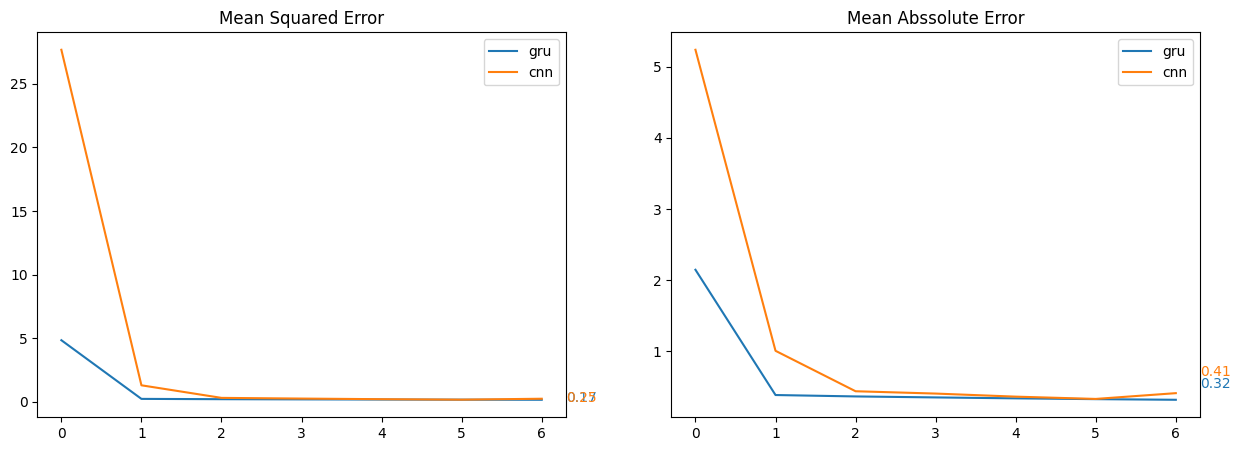

In [34]:
plot_results_sidy_by_side({
    "gru": history_rnn,
    "cnn": history_cnn
})

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!